In [10]:
# Configure the parent path to be the proj folder
import sys, os, torch, time
sys.path.append('../../')

# Import the block classes
from rwkv_block.v7_goose.block.rwkv7_time_mix import RWKV7TimeMix

# File to load
MODEL_FILENAME="v7-1B4.pth"

# Run device, and run dtype to use
RUN_DEVICE="cpu"
RUN_DTYPE=torch.bfloat16

# Check for cuda device
if torch.cuda.is_available():
    RUN_DEVICE="cuda:0"

# Check if the reference weights exists
assert os.path.exists(f"./.model/{MODEL_FILENAME}"), "The reference weights does not exist. Please download it first (00-model-download.ipynb)"

# Loads the model weights
model_weight = torch.load(f"./.model/{MODEL_FILENAME}", map_location='cpu', weights_only=True, mmap=True)

# Model filename
print(f"### Model filename: {MODEL_FILENAME}")

# Lets get the n_dim, and setup the test module
n_dim = model_weight['emb.weight'].shape[1]
print(f"### Model n_dim: {n_dim}")

# # List the model weights keys, and their shapes
# print(f"### model weights keys:")
# for key in model_weight:
#     print(f"{key}: {model_weight[key].shape} - {model_weight[key].dtype}")

### Model filename: v7-1B4.pth
### Model n_dim: 2048


In [11]:
# Initialize the channelmix state, and x state to test
IN_TOKENS_LEN=1
x_state_0 = torch.ones(1, IN_TOKENS_LEN, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE)
x_state_1 = torch.ones(1, IN_TOKENS_LEN, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE)
x_state_2 = torch.ones(1, IN_TOKENS_LEN, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE)
tmix_shift_0 = torch.ones(1, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE)
tmix_shift_1 = torch.ones(1, n_dim, device=RUN_DEVICE, dtype=RUN_DTYPE)
tmix_wkv_0 = torch.ones(1, n_dim // 64, 64, 64, device=RUN_DEVICE, dtype=RUN_DTYPE)
tmix_wkv_1 = torch.ones(1, n_dim // 64, 64, 64, device=RUN_DEVICE, dtype=RUN_DTYPE)

# Iteration to test
TEST_STEPS = 1

# Build the tmix blocks
tmix_pytorch = RWKV7TimeMix({ "n_layer":24, "n_dim":n_dim, "layer_id":0, "device":RUN_DEVICE, "dtype":RUN_DTYPE, "tmix_backend":"pytorch" })
tmix_pytorch.load_from_model_state_dict(model_weight, 0)

tmix_triton = RWKV7TimeMix({ "n_layer":24, "n_dim":n_dim, "layer_id":0, "device":RUN_DEVICE, "dtype":RUN_DTYPE, "tmix_backend":"triton" })
tmix_triton.load_from_model_state_dict(model_weight, 0)

print(f"### Testing the tmix blocks for {TEST_STEPS} steps")

### Testing the tmix blocks for 1 steps


In [12]:
### TMix
with torch.inference_mode():

    # This is a warmup
    t0 = time.time()
    out_x = x_state_0
    t_shift = tmix_shift_0
    t_wkv = tmix_wkv_0
    v_first = x_state_2
    for i in range(TEST_STEPS):
        out_x, t_shift, t_wkv, v_first = tmix_pytorch.forward_with_reduce_compile(x_state_1, t_shift, tmix_wkv_1, v_first)
    t2 = time.time()
    print(f'1 tmix_pytorch reduce-compile forward passes (warmup): {(t2-t0)*1000/TEST_STEPS} ms ({RUN_DEVICE}, {RUN_DTYPE})')

    # The actual run
    t1 = time.time()
    out_x = x_state_0
    t_shift = tmix_shift_0
    t_wkv = tmix_wkv_0
    v_first = x_state_2
    for i in range(TEST_STEPS):
        out_x, t_shift, t_wkv, v_first = tmix_pytorch.forward_with_reduce_compile(x_state_1, t_shift, tmix_wkv_1, v_first)
    t2 = time.time()
    print(f'1 tmix_pytorch reduce-compile forward passes (normal): {(t2-t1)*1000/TEST_STEPS} ms ({RUN_DEVICE}, {RUN_DTYPE})')

1 tmix_pytorch reduce-compile forward passes (warmup): 216.963529586792 ms (cuda:0, torch.bfloat16)
1 tmix_pytorch reduce-compile forward passes (normal): 1.3315677642822266 ms (cuda:0, torch.bfloat16)


In [13]:
### TMix
with torch.inference_mode():

    # This is a warmup
    t0 = time.time()
    out_x = x_state_0
    t_shift = tmix_shift_0
    t_wkv = tmix_wkv_0
    v_first = x_state_2
    for i in range(TEST_STEPS):
        out_x, t_shift, t_wkv, v_first = tmix_triton.forward_with_reduce_compile(x_state_1, t_shift, tmix_wkv_1, v_first)
    t2 = time.time()
    print(f'1 tmix_triton reduce-compile forward passes (warmup): {(t2-t0)*1000/TEST_STEPS} ms ({RUN_DEVICE}, {RUN_DTYPE})')

    # The actual run
    t1 = time.time()
    out_x = x_state_0
    t_shift = tmix_shift_0
    t_wkv = tmix_wkv_0
    v_first = x_state_2
    for i in range(TEST_STEPS):
        out_x, t_shift, t_wkv, v_first = tmix_triton.forward_with_reduce_compile(x_state_1, t_shift, tmix_wkv_1, v_first)
    t2 = time.time()
    print(f'1 tmix_triton reduce-compile forward passes (normal): {(t2-t1)*1000/TEST_STEPS} ms ({RUN_DEVICE}, {RUN_DTYPE})')

1 tmix_triton reduce-compile forward passes (warmup): 91.38083457946777 ms (cuda:0, torch.bfloat16)
1 tmix_triton reduce-compile forward passes (normal): 0.5295276641845703 ms (cuda:0, torch.bfloat16)


In [26]:
### TMix
with torch.inference_mode():

    # Get output with python
    py_out_x, py_t_shift, py_t_wkv, py_v_first = tmix_pytorch.forward_with_reduce_compile(x_state_1, tmix_shift_1, tmix_wkv_1, x_state_2)

    # Get output with triton
    tr_out_x, tr_t_shift, tr_t_wkv, tr_v_first = tmix_triton.forward_with_reduce_compile(x_state_1, tmix_shift_1, tmix_wkv_1, x_state_2)

    # Compute the delta between the two outputs
    py_tr_x = py_out_x - tr_out_x
    py_tr_t_shift = py_t_shift - tr_t_shift
    py_tr_t_wkv = py_t_wkv - tr_t_wkv
    py_tr_v_first = py_v_first - tr_v_first

    # Reshape for display
    delta_tr_x = py_tr_x[-1].view(n_dim // 64, -1).float().cpu().numpy()
    delta_tr_t_wkv = py_tr_t_wkv.view(n_dim // 64 * 8, -1).float().cpu().numpy()
    delta_tr_t_shift = py_tr_t_shift.view(n_dim // 64, -1).float().cpu().numpy()
    delta_tr_v_first = py_tr_x[-1].view(n_dim // 64, -1).float().cpu().numpy()

    # Compute the max delta
    abs_max_delta_tr_x = max(py_tr_x.min().item(), py_tr_t_wkv.max().item())
    abs_max_delta_tr_t_wkv = max(py_tr_t_wkv.min().item(), py_tr_t_wkv.max().item())
    abs_max_delta_tr_t_shift = max(py_tr_t_shift.min().item(), py_tr_t_shift.max().item())
    abs_max_delta_tr_v_first = max(py_tr_v_first.min().item(), py_tr_v_first.max().item())

    # Compute and print the max/min delta
    print("Max delta for x       (shape:", delta_tr_x.shape," max:", delta_tr_x.max().item(),", min:", py_tr_x.min().item(),")")
    print("Max delta for t_wkv   (shape:", delta_tr_t_wkv.shape," max:", delta_tr_t_wkv.max().item(),", min:", py_tr_t_wkv.min().item(),")")
    print("Max delta for t_shift (shape:", delta_tr_t_shift.shape," max:", delta_tr_t_shift.max().item(),", min:", py_tr_t_shift.min().item(),")")
    print("Max delta for v_first (shape:", delta_tr_v_first.shape," max:", delta_tr_v_first.max().item(),", min:", py_tr_v_first.min().item(),")")


Max delta for x       (shape: (32, 64)  max: 11.625 , min: -6.96875 )
Max delta for t_wkv   (shape: (256, 512)  max: 30.375 , min: -33.5 )
Max delta for t_shift (shape: (32, 64)  max: 0.0 , min: 0.0 )
Max delta for v_first (shape: (32, 64)  max: 11.625 , min: -10.0625 )


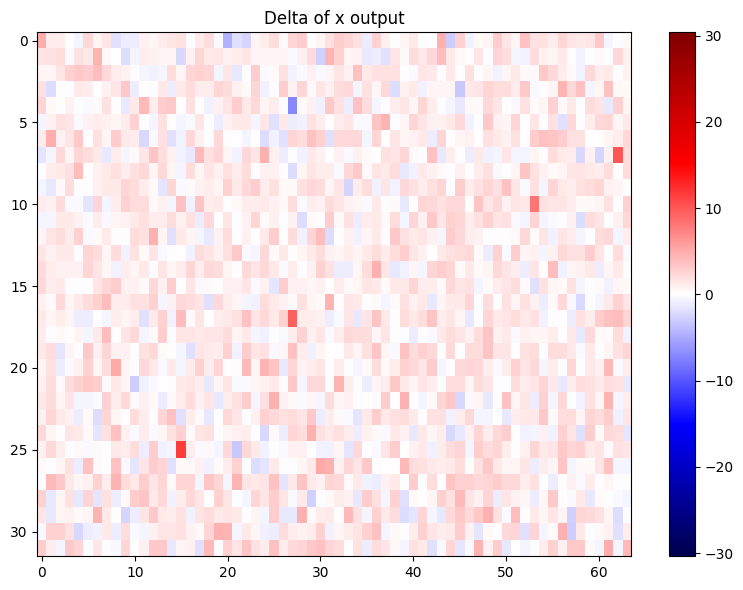

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))  # Set a minimum figure size
im = ax.imshow(delta_tr_x, cmap='seismic', aspect='auto')
im.set_clim(-abs_max_delta_tr_x, abs_max_delta_tr_x)
ax.set_title("Delta of x output")
fig.colorbar(im)
fig.tight_layout()
plt.show()

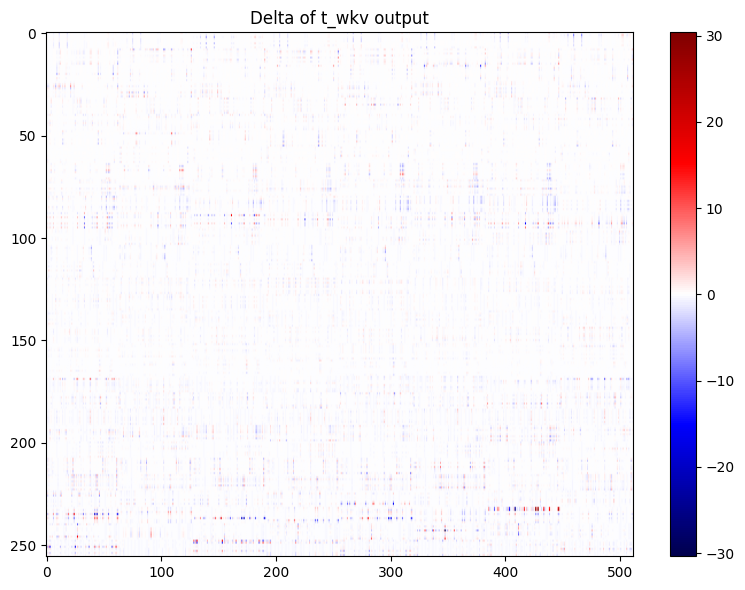

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))  # Set a minimum figure size
im = ax.imshow(delta_tr_t_wkv, cmap='seismic', aspect='auto')
im.set_clim(-abs_max_delta_tr_t_wkv, abs_max_delta_tr_t_wkv)
ax.set_title("Delta of t_wkv output")
fig.colorbar(im)
fig.tight_layout()
plt.show()

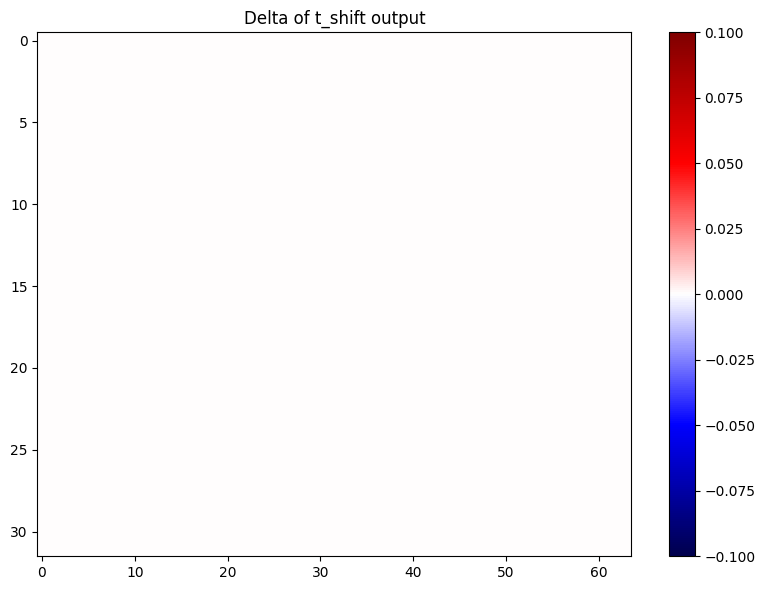

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))  # Set a minimum figure size
im = ax.imshow(delta_tr_t_shift, cmap='seismic', aspect='auto')
im.set_clim(-abs_max_delta_tr_t_shift, abs_max_delta_tr_t_shift)
ax.set_title("Delta of t_shift output")
fig.colorbar(im)
fig.tight_layout()
plt.show()

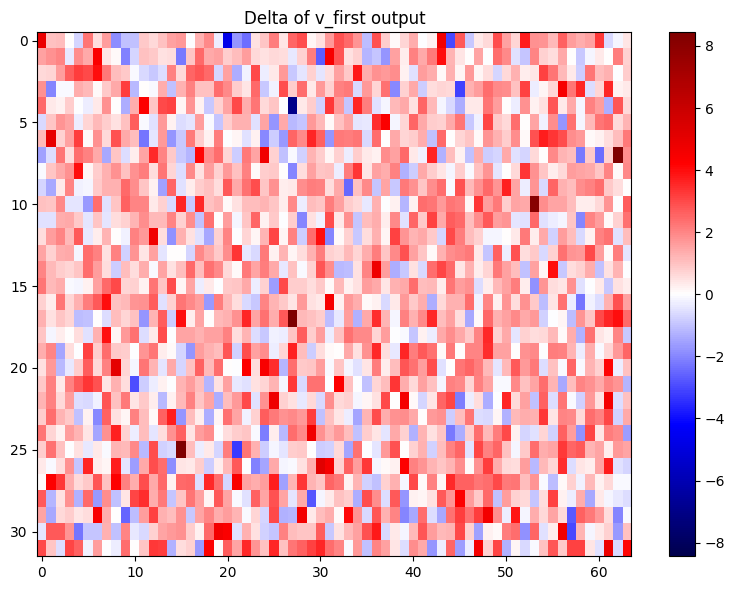

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))  # Set a minimum figure size
im = ax.imshow(delta_tr_v_first, cmap='seismic', aspect='auto')
im.set_clim(-abs_max_delta_tr_v_first, abs_max_delta_tr_v_first)
ax.set_title("Delta of v_first output")
fig.colorbar(im)
fig.tight_layout()
plt.show()